In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

REF_PATH = "/home/yifan/experiments/noise/20/experiment1"
CONFIG_PATH = "/home/yifan/experiments/noise/20"
CLEAN_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:1'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(CONFIG_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,1.0,0.3,0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [2]:

####### generate boundary ponits for tar and ref respectively
from AlignVis.AlignmentBoundaryGenerator import AlignmentBoundaryGenerator
BoundaryGen = AlignmentBoundaryGenerator(REF_PATH,CONFIG_PATH,CLEAN_PATH,CLEAN_PATH,REF_EPOCH,TAR_EPOCH,DEVICE)
ref_boundary,tar_boundary = BoundaryGen.get_boundary_point(DEVICE,num_adv_eg=5000)
import torch
###### get border sample features
import torch.nn as nn

ref_feature_model = ref_model.to(DEVICE)
ref_feature_model = nn.Sequential(*list(ref_feature_model.children())[:-1])
with torch.no_grad():
    features = ref_feature_model(ref_boundary)
    ref_features = features.view(ref_boundary.shape[0], -1).cpu().numpy()

###### get border sample features
tar_feature_model = tar_model.to(DEVICE)
tar_feature_model = nn.Sequential(*list(tar_feature_model.children())[:-1])
with torch.no_grad():
    tar_features = tar_feature_model(tar_boundary)
    tar_features = tar_features.view(tar_boundary.shape[0], -1).cpu().numpy()

NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8579.34it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:01<00:00, 132.34it/s]


conf1 (4002, 10) (4024, 10) (4002, 10) (4024, 10)
conf1 (4002, 10) (4026, 10) (4002, 10) (4026, 10)
conf1 (3972, 10) (4024, 10) (3972, 10) (4024, 10)
conf1 (3996, 10) (4026, 10) (3996, 10) (4026, 10)
conf1 (3997, 10) (3996, 10) (3997, 10) (3996, 10)
conf1 (3949, 10) (4026, 10) (3949, 10) (4026, 10)
conf1 (3972, 10) (4016, 10) (3972, 10) (4016, 10)
conf1 (4024, 10) (3949, 10) (4024, 10) (3949, 10)
conf1 (4024, 10) (4016, 10) (4024, 10) (4016, 10)
conf1 (3996, 10) (3949, 10) (3996, 10) (3949, 10)
conf1 (3996, 10) (3997, 10) (3996, 10) (3997, 10)
conf1 (3997, 10) (4024, 10) (3997, 10) (4024, 10)
conf1 (3980, 10) (4026, 10) (3980, 10) (4026, 10)
conf1 (4002, 10) (3996, 10) (4002, 10) (3996, 10)
conf1 (3972, 10) (4026, 10) (3972, 10) (4026, 10)
conf1 (3996, 10) (3949, 10) (3996, 10) (3949, 10)
conf1 (4002, 10) (3996, 10) (4002, 10) (3996, 10)
conf1 (3997, 10) (4016, 10) (3997, 10) (4016, 10)
conf1 (4002, 10) (3972, 10) (4002, 10) (3972, 10)
conf1 (4024, 10) (3980, 10) (4024, 10) (3980, 10)


In [3]:
######### initialize autoencoder and dataloader #########################
from AlignVisAutoEncoder.autoencoder import SimpleAutoencoder
from AlignVisAutoEncoder.data import DataLoaderInit
input_dim = 512
output_dim = 512

autoencoder = SimpleAutoencoder(input_dim,output_dim)

In [4]:



######### train sample + generated boundary sample's => input  #############
input_X = np.concatenate((ref_provider.train_representation(REF_EPOCH), ref_features),axis=0)
input_Y = np.concatenate((tar_provider.train_representation(TAR_EPOCH), tar_features),axis=0)
data_loader_b = DataLoaderInit(input_X, input_Y)
data_loader = DataLoaderInit(ref_provider.train_representation(REF_EPOCH), tar_provider.train_representation(TAR_EPOCH))
dataloader = data_loader.get_data_loader()
dataloader_b = data_loader_b.get_data_loader()


In [24]:
import torch.optim as optim
import numpy as np
from pyemd import emd
import torch.nn as nn
from scipy.spatial.distance import cdist
from sklearn.neighbors import kneighbors_graph
import torch.nn.functional as F
from AlignVis.losses import KNNOverlapLoss, CKALoss, PredictionLoss, ConfidenceLoss


def earth_movers_distance(X, Y, k=5):
    X, Y = X.detach().numpy(), Y.detach().numpy()
    
    # Compute KNN graphs
    X_knn_graph = kneighbors_graph(X, k, mode='distance')
    Y_knn_graph = kneighbors_graph(Y, k, mode='distance')
    
    # Convert to dense NumPy arrays
    X_knn_matrix = X_knn_graph.toarray()
    Y_knn_matrix = Y_knn_graph.toarray()

    # Calculate the EMD between the KNN distance matrices
    distance_matrix = cdist(X_knn_matrix, Y_knn_matrix)
    first_histogram = np.ones(X_knn_matrix.shape[0]) / X_knn_matrix.shape[0]
    second_histogram = np.ones(Y_knn_matrix.shape[0]) / Y_knn_matrix.shape[0]

    return emd(first_histogram, second_histogram, distance_matrix)

def frobenius_norm_loss(predicted, target):
    return torch.norm(predicted - target, p='fro') / predicted.numel()

def prediction_loss(trans_X, Y):
    
    target_output = tar_provider.get_pred(TAR_EPOCH, Y.detach().numpy())
    # tar_output = self.get_pred(self.TAR_EPOCH, adjusted_input, self.tar_provider.content_path, self.tar_model)
    ref_output = tar_provider.get_pred(TAR_EPOCH, trans_X.detach().numpy())

    loss_ref_output = F.mse_loss(torch.tensor(ref_output), torch.tensor(target_output))
    loss_Rep = F.mse_loss(trans_X, Y)
        
    # loss = loss_tar_output + loss_Rep + self.alpha_for_pred_ref * loss_ref_output
    loss =  loss_Rep + 1 * loss_ref_output
    return loss

from scipy.spatial.distance import directed_hausdorff


def hausdorff_distance(X, Y):
    X, Y = X.detach().numpy(), Y.detach().numpy()

    # Calculate the directed Hausdorff distance from X to Y and from Y to X
    distance_XY = directed_hausdorff(X, Y)[0]
    distance_YX = directed_hausdorff(Y, X)[0]

    # Return the maximum of the two distances
    return max(distance_XY, distance_YX)

# Define hyperparameters
num_epochs = 10
batch_size = 300
learning_rate = 1e-4

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate,weight_decay=1e-5)

alpha = 1 # weight for topological loss, adjust this according to your requirements


# Training loop
for epoch in range(num_epochs):
    # Initialize a list to store the predictions of unlabelled data
    unlabelled_preds = []
    for data_X, data_Y in dataloader_b: # Assuming you have a DataLoader instance with paired data (X, Y)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass (encoding Y and decoding to X's space)
        transformed_Y = autoencoder.encoder(data_Y)
        recon_X = autoencoder.decoder(transformed_Y)

        topological_loss_encoder = earth_movers_distance(data_Y, transformed_Y)
        topological_loss_decoder = earth_movers_distance(data_Y, recon_X)
        
        loss_f_decoder = frobenius_norm_loss(recon_X, data_X) + 10 * topological_loss_decoder
        loss_f_encoder = frobenius_norm_loss(transformed_Y, data_X) + topological_loss_encoder

        pred_loss = prediction_loss(recon_X, data_Y)

        #### CKA loss
        cka_loss_f = CKALoss(gamma=None, alpha=1e-8)
        cka_loss = cka_loss_f(data_Y,transformed_Y,recon_X)

        hausdorff_loss = hausdorff_distance(data_Y, transformed_Y) + hausdorff_distance(data_Y, recon_X)

        loss = loss_f_decoder + loss_f_encoder + 0.1 * pred_loss + cka_loss + hausdorff_loss

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()


    # Print the loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Loss decoder: {loss_f_decoder.item():.4f},Loss encoder: {loss_f_encoder.item():.4f},pred_loss,{pred_loss.item():.4f},CKA,{cka_loss.item():.4f},hausdorff_loss,{hausdorff_loss}')

torch.save({
    'epoch': TAR_EPOCH,
    'model_state_dict': autoencoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, "/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/ref_noise_hostff.pth")


100%|██████████| 1/1 [00:00<00:00, 3975.64it/s]


Epoch [1/10], Loss: 31.4309, Loss decoder: 0.0073,Loss encoder: 0.0042,pred_loss,0.2487,CKA,0.0001,hausdorff_loss,31.394366683531594


100%|██████████| 1/1 [00:00<00:00, 2669.83it/s]


Epoch [2/10], Loss: 35.5076, Loss decoder: 0.0077,Loss encoder: 0.0045,pred_loss,0.2539,CKA,0.0001,hausdorff_loss,35.46988477328532


100%|██████████| 1/1 [00:00<00:00, 3971.88it/s]


Epoch [3/10], Loss: 27.1661, Loss decoder: 0.0071,Loss encoder: 0.0041,pred_loss,0.2655,CKA,0.0001,hausdorff_loss,27.128201133462674


100%|██████████| 1/1 [00:00<00:00, 3738.24it/s]


Epoch [4/10], Loss: 30.8099, Loss decoder: 0.0079,Loss encoder: 0.0045,pred_loss,0.3041,CKA,0.0001,hausdorff_loss,30.767027921253547


100%|██████████| 1/1 [00:00<00:00, 3942.02it/s]


Epoch [5/10], Loss: 31.5838, Loss decoder: 0.0074,Loss encoder: 0.0042,pred_loss,0.2046,CKA,0.0001,hausdorff_loss,31.551651671832165


100%|██████████| 1/1 [00:00<00:00, 3916.25it/s]


Epoch [6/10], Loss: 31.0154, Loss decoder: 0.0074,Loss encoder: 0.0043,pred_loss,0.2560,CKA,0.0001,hausdorff_loss,30.978034256456944


100%|██████████| 1/1 [00:00<00:00, 5614.86it/s]


Epoch [7/10], Loss: 30.8139, Loss decoder: 0.0074,Loss encoder: 0.0044,pred_loss,0.2753,CKA,0.0001,hausdorff_loss,30.774486988288444


100%|██████████| 1/1 [00:00<00:00, 5171.77it/s]


Epoch [8/10], Loss: 32.6647, Loss decoder: 0.0075,Loss encoder: 0.0044,pred_loss,0.2794,CKA,0.0001,hausdorff_loss,32.62474298194052


100%|██████████| 1/1 [00:00<00:00, 5377.31it/s]


Epoch [9/10], Loss: 25.0685, Loss decoder: 0.0075,Loss encoder: 0.0044,pred_loss,0.2501,CKA,0.0001,hausdorff_loss,25.03151863936189


100%|██████████| 1/1 [00:00<00:00, 4524.60it/s]

Epoch [10/10], Loss: 27.7659, Loss decoder: 0.0072,Loss encoder: 0.0041,pred_loss,0.2412,CKA,0.0002,hausdorff_loss,27.730279716420117


In [25]:
###### use auto encoder to visualize the prediction
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)

# Transform Y into X's space
encoded_Y = autoencoder.encoder(Y)
c_y = encoded_Y.detach().numpy()

from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
# indicates = np.random.choice(aligned, size=10, replace=False)
indicates = np.random.choice(np.arange(5000), size=1000, replace=False)
print('CKA between  target vs target is:         ',np_cka.kernel_CKA(Y[indicates],Y[indicates]))
# print('CKA between target and linear_target:     ',np_cka.kernel_CKA(Y[indicates],np.dot(Y[indicates],R_n_2.detach().numpy())))
print('CKA between target and autoencoder_target:',np_cka.kernel_CKA(Y[indicates],c_y[indicates]))
print('CKA between  ref vs autoencoder_target is:',np_cka.kernel_CKA(X[indicates],c_y[indicates]))
print('CKA between  ref vs target is:            ',np_cka.kernel_CKA(X[indicates],c_y[indicates]))

CKA between  target vs target is:          1.0
CKA between target and autoencoder_target: 0.9997682082771844
CKA between  ref vs autoencoder_target is: 0.5306002337622463
CKA between  ref vs target is:             0.5306002337622463


Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8535.00it/s]


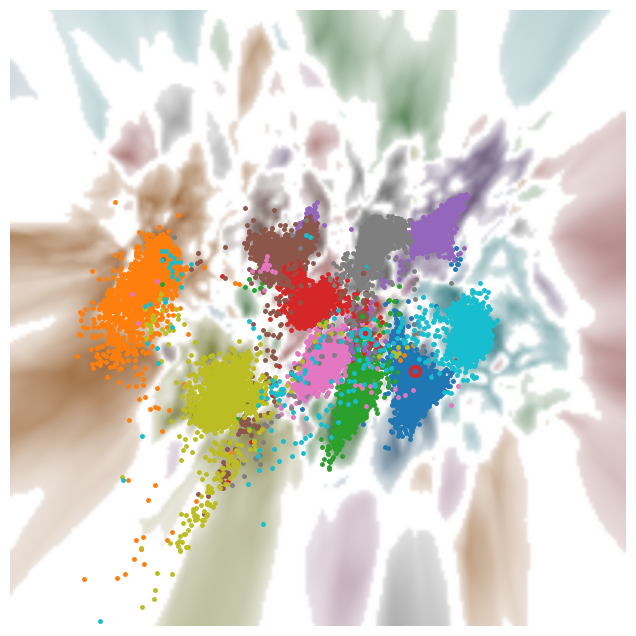

In [26]:
# checkpoint = torch.load("/home/yifan/projects/deepdebugertool/DLVisDebugger/AlignVisAutoEncoder/checkpoints/noise_flap.pth")
# autoencoder.load_state_dict(checkpoint['model_state_dict'])
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'baseline'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)

I = np.eye(512)
from AlignVisAutoEncoder.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8259.11it/s]


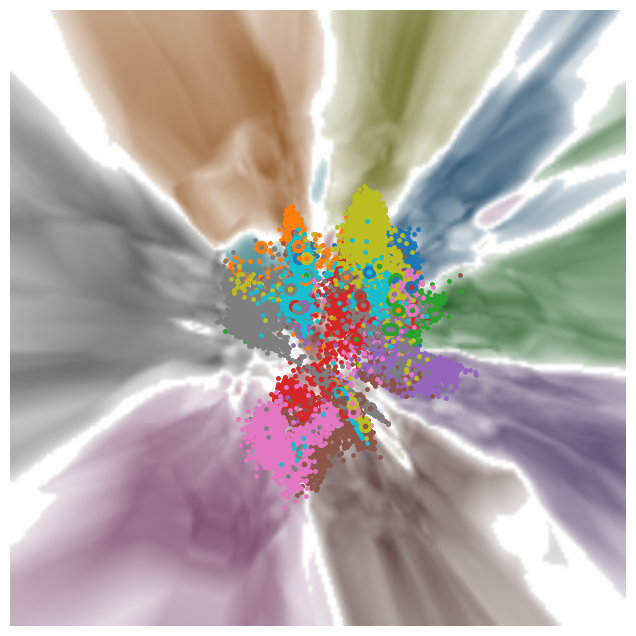

In [7]:
###### use auto encoder to visualize the prediction
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)
VIS_MODEL_NAME = 'vis'
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
###### use auto encoder to visualize the prediction
Y = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
X = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)

# Transform Y into X's space
encoded_Y = autoencoder.encoder(Y)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVisAutoEncoder.visualizer_inv import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_X.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 4524.64it/s]


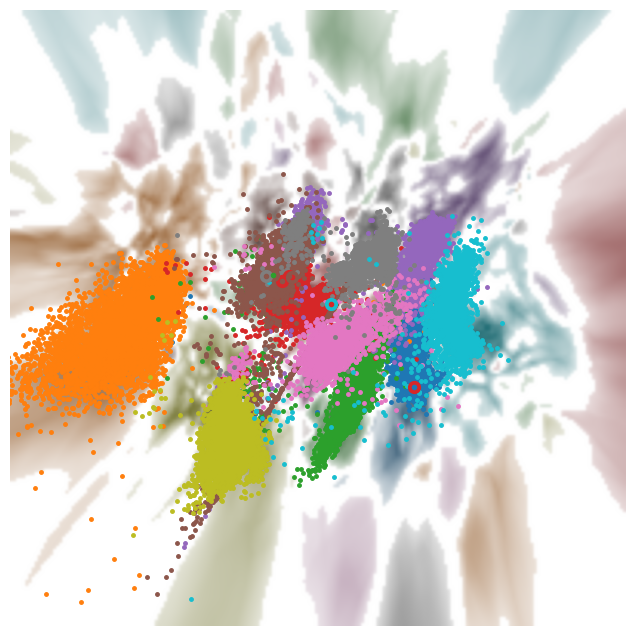

In [17]:
###### use auto encoder to visualize the prediction
X = torch.Tensor(ref_provider.train_representation(REF_EPOCH))
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
# Transform X into Y's space
encoded_X = autoencoder.decoder(X)
VIS_MODEL_NAME = 'baseline'
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVisAutoEncoder.visualizer_inv import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, tar_provider, autoencoder, np.dot(encoded_X.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9437.38it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

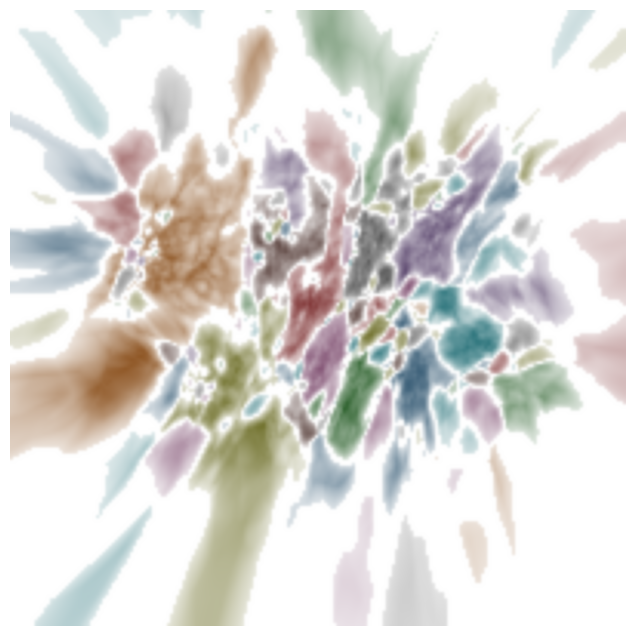

In [8]:


import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'baseline'
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
# from AlignVisAutoEncoder.visualizer_inv import visualizer
from representationTrans.trans_visualizer_border import visualizer
vis = visualizer(tar_provider, I,I, np.dot(tar_train_data, I), projector, 200,[[]],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img2.png"))

In [9]:
from AlignVis_eval.Alignmenteval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)

In [10]:
eval.eval_boundary_nn_autoencoder(tar_features, autoencoder)

#train# boundary preserving: 1.18/15 in epoch 200


1.18216

In [15]:
eval.eval_nn_train_ref_in_ref(15)

Thu Apr 20 15:36:17 2023 Building RP forest with 16 trees
Thu Apr 20 15:36:17 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	Stopping threshold met -- exiting after 6 iterations
Thu Apr 20 15:36:19 2023 Building RP forest with 16 trees
Thu Apr 20 15:36:19 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving ref in ref: 1.26/15 in epoch 200


1.2603

In [13]:
eval.eval_nn_train_autoencoder(15,autoencoder )

Thu Apr 20 15:35:16 2023 Building RP forest with 16 trees
Thu Apr 20 15:35:17 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Thu Apr 20 15:35:19 2023 Building RP forest with 16 trees
Thu Apr 20 15:35:19 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for autoencoder: 1.22/15 in epoch 200


1.2204

In [12]:
from singleVis.eval.evaluate import *

train_data = encoded_Y.detach().numpy()
embedding = projector.batch_project(REF_EPOCH, train_data)
inv_data = projector.batch_inverse(REF_EPOCH, embedding)
new_inv = autoencoder.decoder(torch.Tensor(inv_data))
new_inv = new_inv.detach().numpy()
####### target prediction
pred = tar_provider.get_pred(TAR_EPOCH, tar_provider.train_representation(TAR_EPOCH)).argmax(axis=1)
new_pred = tar_provider.get_pred(REF_EPOCH, new_inv).argmax(axis=1)

val = evaluate_inv_accu(pred, new_pred)
       
print("#train# autoencoder PPR: {:.2f} in epoch {:d}".format(val, REF_EPOCH))


100%|██████████| 250/250 [00:00<00:00, 8578.50it/s]

#train# autoencoder PPR: 0.97 in epoch 200
